# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [17]:
import cv2
import numpy as np
import tensorflow as tf
from google.colab import files
from tensorflow.keras.applications import vgg16

print(tf.__version__)
print(tf.executing_eagerly())

2.13.0
True


In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
print("GPU доступен:", tf.config.list_physical_devices('GPU'))

GPU доступен: []


## Функции загрузки данных

In [12]:
uploaded = files.upload()

Saving cats-dogs-vgg16.hdf5 to cats-dogs-vgg16 (1).hdf5


In [ ]:
!unzip '/content/train.zip'

In [19]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('/content/train/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=128):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

In [20]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

<Figure size 1600x800 with 0 Axes>

## Загружаем предобученную модель

In [6]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Добавляем полносвязный слой

In [ ]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

output_layer = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = Model(inputs=base_model.input, outputs=output_layer, name='dogs_vs_cats')

## Выводим архитектуру модели

In [ ]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

## Компилируем модель и запускаем обучение

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [ ]:
val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(train_data,
          steps_per_epoch=200,  # число вызовов генератора за эпоху
          epochs=20,  # число эпох обучения
          validation_data=validation_data,
          callbacks=[early_stopping])

Epoch 1/20
200/200 [==============================] - 165s 824ms/step - loss: 0.0687 - accuracy: 0.9798 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 2/20
200/200 [==============================] - 164s 819ms/step - loss: 0.0446 - accuracy: 0.9846 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 3/20
200/200 [==============================] - 164s 820ms/step - loss: 0.0313 - accuracy: 0.9898 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 4/20
200/200 [==============================] - 164s 821ms/step - loss: 0.0262 - accuracy: 0.9904 - val_loss: 0.0762 - val_accuracy: 1.0000
Epoch 5/20
200/200 [==============================] - 164s 822ms/step - loss: 0.0213 - accuracy: 0.9923 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 6/20
200/200 [==============================] - 164s 820ms/step - loss: 0.0203 - accuracy: 0.9934 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 7/20
200/200 [==============================] - 164s 819ms/step - loss: 0.0226 - accuracy: 0.9921 - val_loss: 0.2819 -

In [ ]:
model.save('cats-dogs-vgg16_2.hdf5')

## Предсказания на проверочной выборке

In [ ]:
!unzip '/content/test.zip'

In [10]:
test_files = glob('/content/test/*.jpg')

In [13]:
model = tf.keras.models.load_model('/content/cats-dogs-vgg16 (1).hdf5')

In [15]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

12500/12500 [==============================] - 7389s 591ms/step


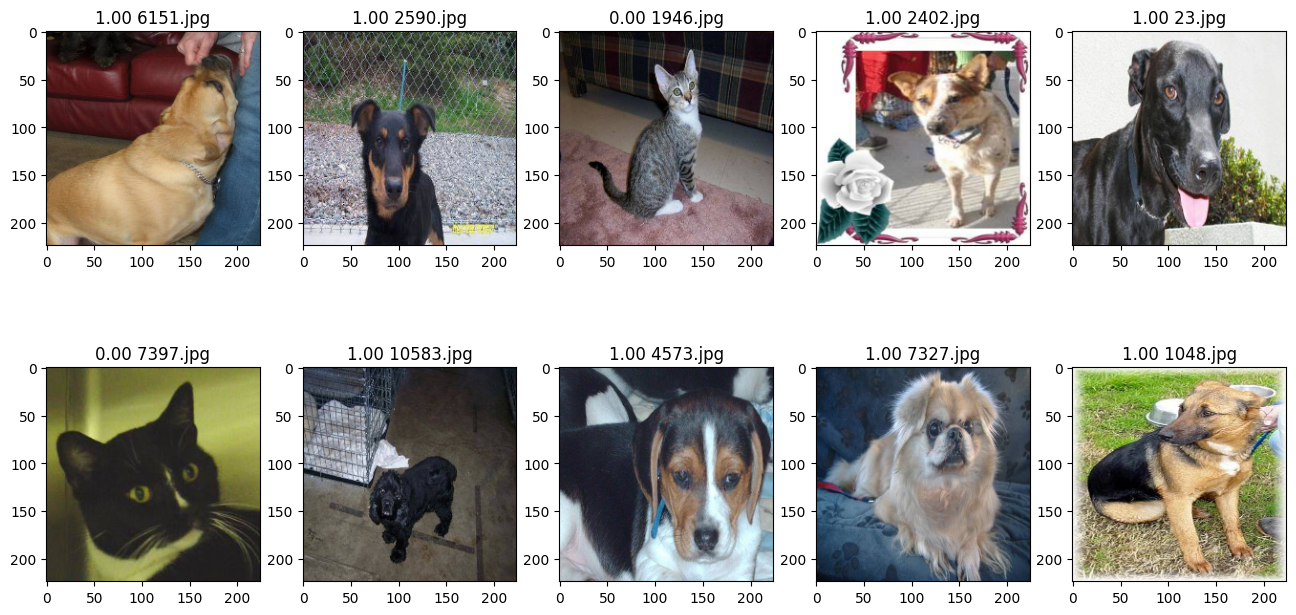

In [21]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [23]:
import re

with open('submit.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

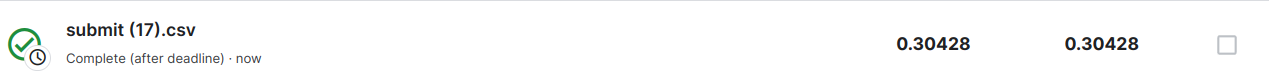